## Equally-Weighted Portfolio Backtest.

In [6]:
from __future__ import annotations

In [7]:
import pandas as pd
from qamsi.config.trading_config import TradingConfig
from qamsi.runner import Runner
from qamsi.strategies.heuristics.equally_weighted import EWStrategy
from qamsi.features.preprocessor import Preprocessor
from run import Dataset

In [8]:
REBAL_FREQ = "ME"
DATASET = Dataset.SPX_US

In [9]:
experiment_config = DATASET.value()

stocks = tuple(
    pd.read_csv(experiment_config.PATH_OUTPUT / experiment_config.STOCKS_LIST_FILENAME)
    .iloc[:, 0]
    .astype(str)
    .tolist(),
)
experiment_config.ASSET_UNIVERSE = stocks  # type: ignore  # noqa: PGH003

experiment_config.N_LOOKBEHIND_PERIODS = None
experiment_config.REBALANCE_FREQ = REBAL_FREQ

factors = pd.read_csv(experiment_config.PATH_OUTPUT / "factors.csv")
factors["date"] = pd.to_datetime(factors["date"])
factors = factors.set_index("date")
factor_names = tuple(factors.columns.astype(str).tolist())
experiment_config.FACTORS = factor_names

prices = [stock + "_Price" for stock in list(stocks)]
preprocessor = Preprocessor(
    exclude_names=[
        *list(stocks),
        experiment_config.RF_NAME,
        *experiment_config.HEDGING_ASSETS,
        *factor_names,
        *prices,
    ],
)

trading_config = TradingConfig(
    broker_fee=0.05 / 100,
    bid_ask_spread=0.03 / 100,
    total_exposure=1,
    max_exposure=1,
    min_exposure=0,
    trading_lag_days=1,
)

runner = Runner(
    experiment_config=experiment_config,
    trading_config=trading_config,
    verbose=True,
)

Backtest on 2000-12-29 00:00:00 to 2023-12-18 00:00:00
Num Train Iterations: 277
Num OOS Daily Points: 5778


In [10]:
strategy = EWStrategy()

strategy_name = strategy.__class__.__name__

result = runner(
    feature_processor=preprocessor,
    strategy=strategy,
    hedger=None,
)
result

Computing Weights: 100%|██████████| 277/277 [00:27<00:00, 10.08it/s]


StrategyStatistics:
* final_nav = 8.545151
* geom_avg_total_r = 0.122822
* geom_avg_xs_r = 0.115557
* std_xs_r = 0.232921
* min_xs_r = -0.119280
* max_xs_r = 0.113693
* skew = -0.218743
* kurtosis = 9.582890
* max_dd = -0.606175
* sharpe = 0.496120
* alpha_buy_hold = 0.051965
* tracking_error_buy_hold = 0.052733
* ir_buy_hold = 0.985446
* factor_loadings = {'low_risk': -0.3112152769892885, 'momentum': 0.045766800164706245, 'quality': 0.03532531703155174, 'size': 0.10417783821265289, 'value': 0.3659887692123542, 'spx': 0.9399021415698775}
* alpha_benchmark = 0.043073
* alpha_benchmark_pvalue = 0.000002
* tracking_error_benchmark = 0.035815
* ir_benchmark = 1.202652
* ttest_pval = 0.245407
* levene_pval = 0.000281
* timing_ability_coef = -0.016013
* timing_ability_pval = 0.054738

In [11]:
result.std_xs_r

np.float64(0.23292148319517608)

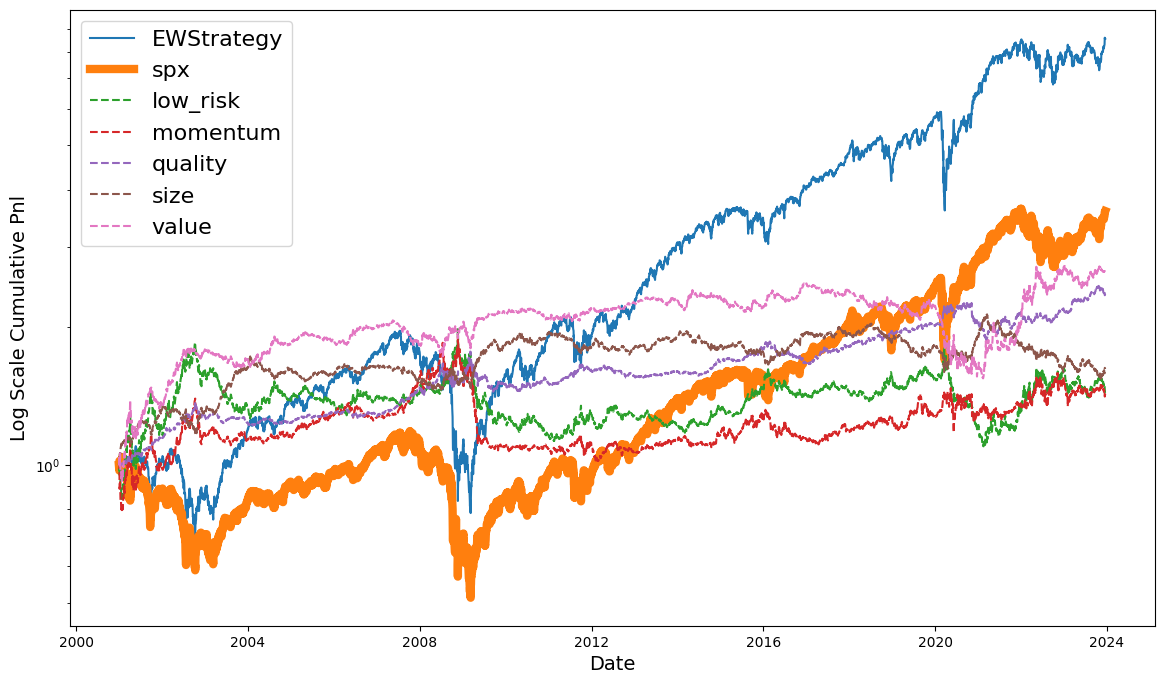

In [12]:
runner.plot_cumulative(
    strategy_name=strategy_name,
    include_factors=True,
)

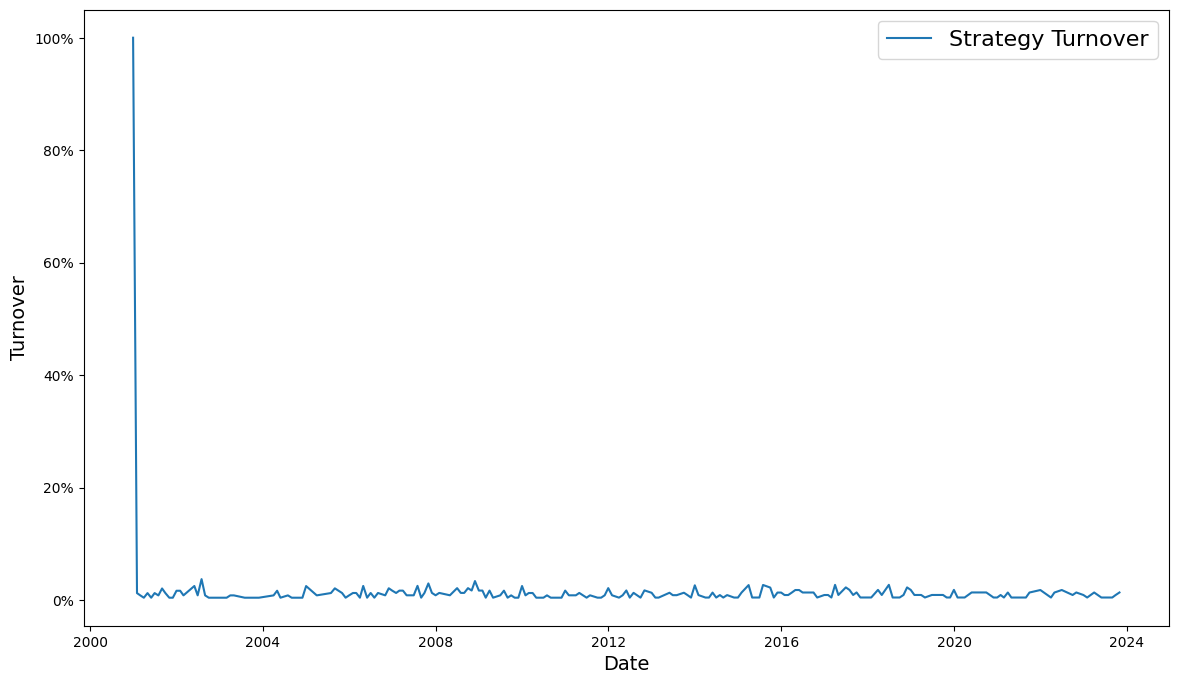

In [13]:
runner.plot_turnover()

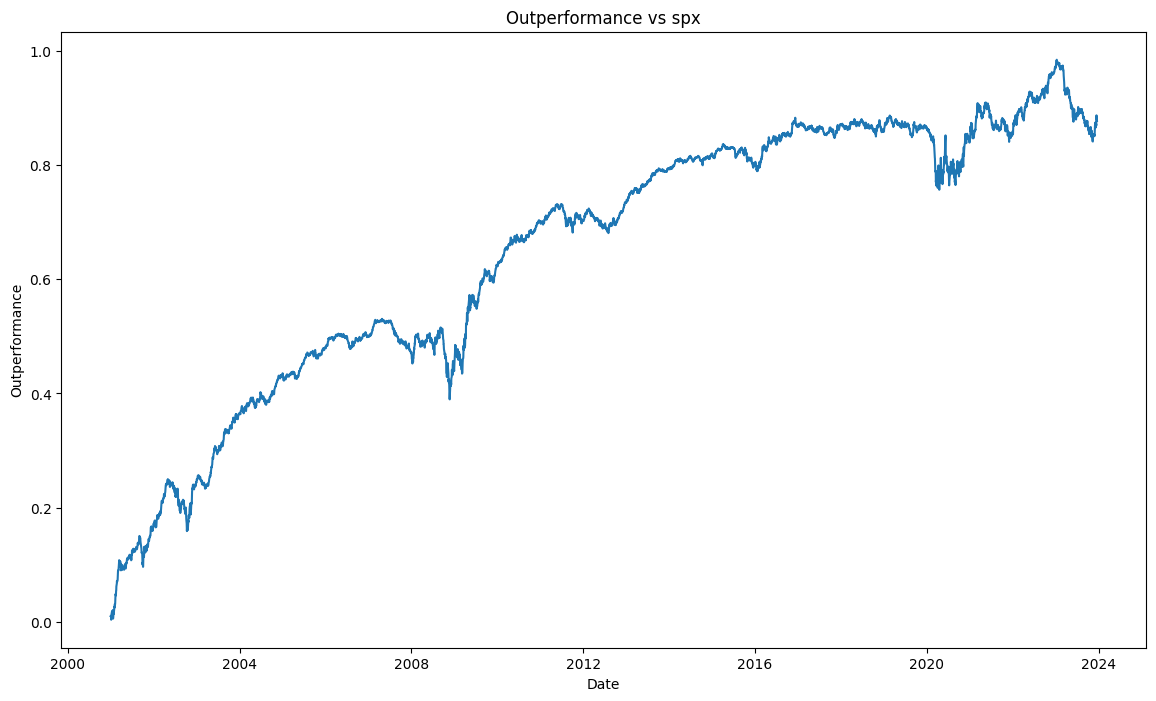

In [14]:
runner.plot_outperformance(mkt_only=True)

In [15]:
runner.save(DATASET.name + strategy_name + f"_rebal{REBAL_FREQ}")